In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import gamma as gamma_func
from scipy.stats import gamma, expon, norm
from tqdm.auto import tqdm
import arviz as az

%load_ext lab_black

# 11. Gamma Gamma*

From [Unit 4: gammagamma.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit4/gammagamma.m).

## Translation of the lecture's MATLAB code

First, here's a direct translation of the professor's MATLAB code, with some minor adjustments to the plots. He didn't include how to find $k(\alpha)$ in this version.

HPD credible set: [0.024568994513107345 0.27407917790064795]
Probability within hpd bounds: 0.9500000000000203
length of hpd cs: 0.2495101833875406


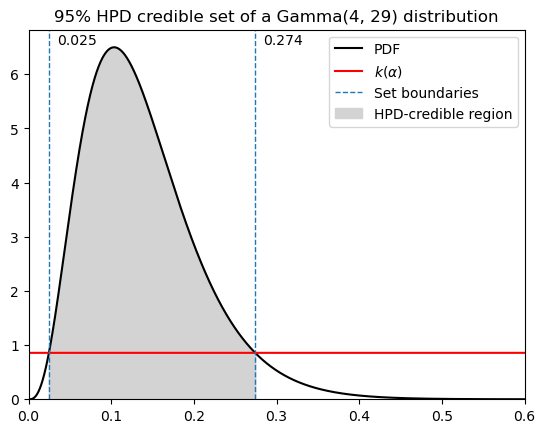

In [2]:
# hpd credible set

k = 0.857368863848
a, b = 4, 29

lower_hpd = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, 0.05)[0]
upper_hpd = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, 0.4)[0]
print(f"HPD credible set: [{lower_hpd} {upper_hpd}]")

prob_hpd = gamma.cdf(upper_hpd, a, scale=1 / b) - gamma.cdf(lower_hpd, a, scale=1 / b)
print(f"Probability within hpd bounds: {prob_hpd}")
print(f"length of hpd cs: {upper_hpd - lower_hpd}")

xx = np.linspace(0, 1, 1000000)
pdf = gamma.pdf(xx, a=a, scale=1 / b)

# density curve
plt.plot(xx, pdf, color="black", label="PDF")

# additional markings
plt.plot(xx, np.full_like(xx, 0.857), "r-", label="$k(\\alpha)$")
plt.axvline(lower_hpd, linestyle="dashed", linewidth=1, label="Set boundaries")
plt.axvline(upper_hpd, linestyle="dashed", linewidth=1)

plt.fill_between(
    xx,
    pdf,
    where=(lower_hpd < xx) & (xx < upper_hpd),
    color="lightgrey",
    label="HPD-credible region",
)
plt.legend()
plt.title("95% HPD credible set of a Gamma(4, 29) distribution")
plt.ylim(bottom=0)
plt.xlim(left=0, right=0.6)
plt.text(lower_hpd + 0.01, 6.55, f"{lower_hpd:.3f}", rotation=0)
plt.text(upper_hpd + 0.01, 6.55, f"{upper_hpd:.3f}", rotation=0)
plt.show()

Equitailed credible set: [0.037581564607804305 0.3023197610255974]
Probability within eqt bounds: 0.95
length of eqt cs: 0.26473819641779306


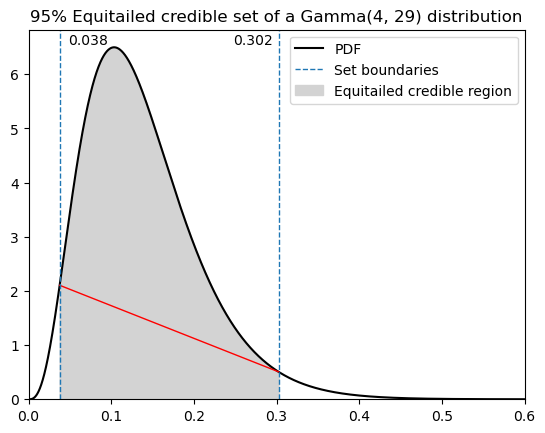

In [3]:
# equi-tailed credible set

# percent point function aka inverse cdf
lower_eqt = gamma.ppf(0.025, a, scale=1 / b)
upper_eqt = gamma.ppf(0.975, a, scale=1 / b)
print(f"Equitailed credible set: [{lower_eqt} {upper_eqt}]")

prob_eqt = gamma.cdf(upper_eqt, a, scale=1 / b) - gamma.cdf(lower_eqt, a, scale=1 / b)
print(f"Probability within eqt bounds: {prob_eqt}")
print(f"length of eqt cs: {upper_eqt - lower_eqt}")

# density curve
plt.plot(xx, pdf, color="black", label="PDF")

# additional markings
plt.plot(
    [lower_eqt, upper_eqt],
    [gamma.pdf(lower_eqt, a, scale=1 / b), gamma.pdf(upper_eqt, a, scale=1 / b)],
    "r-",
    linewidth=1,
)
plt.axvline(lower_eqt, linestyle="dashed", linewidth=1, label="Set boundaries")
plt.axvline(upper_eqt, linestyle="dashed", linewidth=1)

plt.fill_between(
    xx,
    pdf,
    where=(lower_eqt < xx) & (xx < upper_eqt),
    color="lightgrey",
    label="Equitailed credible region",
)
plt.legend()
plt.title("95% Equitailed credible set of a Gamma(4, 29) distribution")
plt.ylim(bottom=0)
plt.xlim(left=0, right=0.6)
plt.text(lower_eqt + 0.01, 6.55, f"{lower_eqt:.3f}", rotation=0)
plt.text(upper_eqt - 0.055, 6.55, f"{upper_eqt:.3f}", rotation=0)
plt.show()

## Find the HPD credible interval when you don't know k

A student in the Spring 2022 class was wondering where the .05 and .4 values entered to ```fsolve()``` came from. They're just your guesses for the lower and upper bounds of the credible interval. They give the optimizer a starting point.

That led to the bigger question of where to find $k(α)$, which is a horizontal line that intersects the posterior PDF at the lower and upper bounds of your HPD credible interval. The reason we want a horizontal line is that this ensures that you've got the shortest interval covering credibility $1 - α$ (we usually choose a credibility of .95 in this course, but that's arbitrary).

I don't know how the professor did it originally, but here are two approaches to estimate the HPD interval. Both assume that the posterior is unimodal, but could be extended to account for multimodal cases.

### Optimization methods

If our posterior is a known distribution, we can use optimization to find $k(\alpha)$.

This first one is a brute force method; pretty much just trying lots of values for $k$ (this was how the head TA did it when I took this course):

1. Loop over a bunch of possible k values, each time using a function like [```scipy.optimize.fsolve()```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) on the pdf of your posterior minus k. This will solve for the location that your pdf intersects with k. You need to feed the optimizer an initial guess, near the lower bound of the credible interval, and one near the upper bound.

2. Evaluate the posterior CDF at each bound, then subtract the results to get the probability the posterior falls within those bounds. If it's close enough to 1 - α, you can stop the loop because you have your answer. If not, the loop continues.

In [4]:
# Finding the HPD credible set

# our pdf is Gamma(4, 29) where 29 is the rate.
# looking at the plot, k must be between 0-2

a, b = 4, 29
alpha = 0.05
tolerance = 0.0001
iterations = 20000

# initial guesses
guess_lwr = 0.05
guess_upr = 0.4
possible_k = np.linspace(0, 2, iterations)
success = 0
# if loop finishes without printing anthing, no solution within given tolerance
# try adjusting tolerance, initial guesses, range of possible_k
for k in tqdm(possible_k):
    lower = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, guess_lwr)[0]
    upper = fsolve(lambda x: gamma.pdf(x, a, scale=1 / b) - k, guess_upr)[0]
    prob = gamma.cdf(upper, a, scale=1 / b) - gamma.cdf(lower, a, scale=1 / b)
    if abs(prob - (1 - alpha)) <= tolerance:
        success = 1
        break

assert success == 1, "Credible set within given tolerance not found!"

print(f"{k=}")
print(f"HPD credible set: {lower, upper}")
print(f"length = {upper - lower}")
print(f"probability within these bounds: {prob}")

  0%|          | 0/20000 [00:00<?, ?it/s]

/Users/aaron/mambaforge/envs/pymc_env2/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


k=0.855942797139857
HPD credible set: (0.02455112335043536, 0.2741713733854568)
length = 0.24962025003502142
probability within these bounds: 0.950094289217813


This brute-force method is really finicky, you might find yourself needing to adjust the tolerance and initial guesses quite a bit. It helps to base your guesses off visual inspection of a plot of the posterior.
### Better optimization method
But we can do better! Instead of trying a bunch of different guesses for k, solve for where two conditions are met:

1. The pdf must evaluate to the same density at each bound (so k is horizontal).
2. The probability within those bounds must be equal to 1 - alpha.

In [5]:
guess_lwr, guess_upr = 0.05, 0.4

def conditions(x):
    a = 4
    b = 29
    alpha = 0.05
    lwr, upr = x

    cond_1 = gamma.pdf(upr, a, scale=1 / b) - gamma.pdf(lwr, a, scale=1 / b)
    cond_2 = (
        gamma.cdf(upr, a, scale=1 / b) - gamma.cdf(lwr, a, scale=1 / b) - (1 - alpha)
    )

    return cond_1, cond_2


fsolve(conditions, (guess_lwr, guess_upr))

array([0.02456899, 0.27407918])

### Sampling method

```{epigraph}
Working with samples transforms a problem in calculus into a problem in data summary, into a frequency format problem. An integral in a typical Bayesian context is just the total probability in some interval. That can be a challenging calculus problem. But once you have samples from the probability distribution, it’s just a matter of counting values in the interval.

-- {cite:t}`mcelreath2020statistical` Chapter 3, p. 51
```

There's another way that I find simpler, which involves sampling lots of values from the posterior. This is also the way it's generally done in practice, since using MCMC we'll only be getting samples from the posterior anyways. See the source code for HPD or HDI functions in many Bayesian libraries like [Arviz](https://arviz-devs.github.io/arviz/_modules/arviz/stats/stats.html#hdi) or [MCMCChains.jl](https://github.com/TuringLang/MCMCChains.jl/blob/master/src/stats.jl).

This method is simplified - it won't work for as many different cases as the ones in those packages, but it's easier to understand.

1. Draw some samples from your posterior.
2. Sort them from smallest to largest.
3. Compute the possible credible intervals.
4. Take the one with the minimum width.

See [Chen and Shao, 1999](https://www.jstor.org/stable/1390921) for the math.

In [6]:
def calc_hdi(samples: np.ndarray, alpha: float = 0.05) -> tuple:
    """
    Calculate minimum-width credible interval (HPD credible set)

    samples: samples from posterior
    alpha: credibility of the interval == 1 - alpha

    returns tuple of the lower and upper bounds of the interval
    """
    n = len(samples)
    x = np.sort(samples)

    lower_idx = int(np.floor(alpha * n))
    x_left = x[:lower_idx]
    x_right = x[n - lower_idx :]

    idx = np.argmin(x_right - x_left)

    upper_bound = x_right[idx]
    lower_bound = x_left[idx]

    return lower_bound, upper_bound


a = 4
b = 29

samples = gamma.rvs(a, scale=1 / b, size=1000000)
lower, upper = calc_hdi(samples, alpha=0.05)

# double-check credibility
prob = gamma.cdf(upper, a, scale=1 / b) - gamma.cdf(lower, a, scale=1 / b)

print(f"HPD credible set: {lower, upper}")
print(f"length = {upper - lower}")
print(f"probability within these bounds: {prob}")

HPD credible set: (0.02493144111405501, 0.2741742426814393)
length = 0.2492428015673843
probability within these bounds: 0.949765416951921


In [7]:
# use np.quantile for equitailed credible sets

a = 4
b = 29
n = 1000000
samples = gamma.rvs(a, scale=1 / b, size=n)

x = np.sort(samples)
alpha = 0.05

lower_idx = int(np.floor(alpha / 2 * n))
upper_idx = int(np.floor((1 - alpha / 2) * n))

print(f"manual = {x[lower_idx], x[upper_idx]}")

np.quantile(samples, (0.025, 0.975))

manual = (0.0374947855071559, 0.3023844372760703)


array([0.03749478, 0.30238431])

## Additional examples

The previous example goes over HPD and equi-tailed credible intervals for a gamma distribution. With a known distribution, you can use the inverse cdf for equi-tailed and the optimization method for the HPD set. 

But you need to be careful with the optimization method, you can't always plug in every posterior to that function and get the right answer.

### Exponential distribution

This distribution is monotonically decreasing. How does that affect our credible interval calculations?

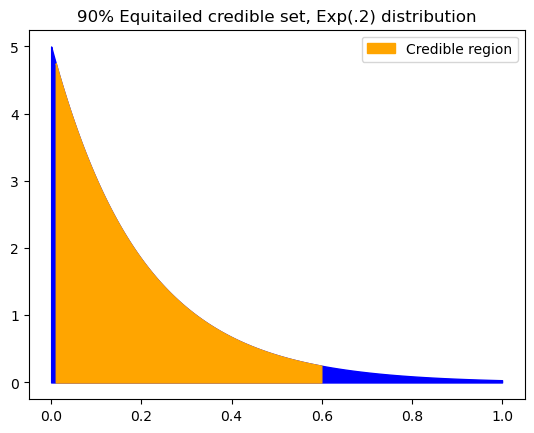

0.0103, 0.5991


In [8]:
xx = np.linspace(0, 1, 1000000)
pdf = expon.pdf(xx, scale=0.2)

# equitailed
low, high = expon.ppf(0.05, scale=0.2), expon.ppf(0.95, scale=0.2)

plt.plot(xx, pdf, alpha=0)
plt.fill_between(xx, pdf, color="blue")
plt.fill_between(
    xx, pdf, where=(low < xx) & (xx < high), color="orange", label="Credible region"
)
plt.title("90% Equitailed credible set, Exp(.2) distribution")
plt.legend()
plt.show()
print(f"{low:.4f}, {high:.4f}")

By definition, the equi-tailed credible interval must leave the same density out on both sides (the blue in the plot above). But clearly this is not a great representation of the distribution.

Someone in the Fall 2022 semester asked how to use the $k(\alpha)$ method to get the HPD credible set of an exponential distribution. Remember that making use of $k(\alpha)$ is just a means to an end; what we really want is the minimum-width credible set, being the shortest interval that satisfies the given alpha value.

In this case, we can see that the left endpoint must be zero.

In [9]:
upper_guess = 0.75


def conditions(x):
    alpha = 0.1
    cond = expon.cdf(x, scale=0.2) - (1 - alpha)

    return cond


upper = fsolve(conditions, upper_guess)[0]

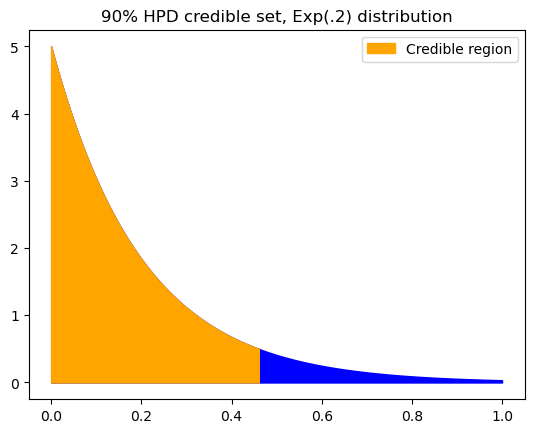

0, 0.4605


In [10]:
plt.plot(xx, pdf, alpha=0)
plt.fill_between(xx, pdf, color="blue")
plt.fill_between(
    xx, pdf, where=(0 < xx) & (xx < upper), color="orange", label="Credible region"
)
plt.title("90% HPD credible set, Exp(.2) distribution")
plt.legend()
plt.show()
print(f"0, {upper:.4f}")

In [11]:
calc_hdi(expon.rvs(scale=0.2, size=1000000))

(4.025193706797135e-07, 0.5996050204374016)

### Mixtures and multimodal distributions

What if we have a posterior where we don't have all these nice builtin functions like the inverse cdf?

For example, a mixture of two distributions.

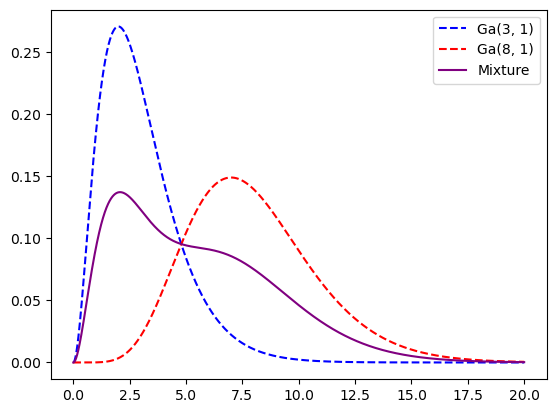

In [12]:
xx = np.linspace(0, 20, 1000000)

dist1 = gamma(a=3, scale=1)
dist2 = gamma(a=8, scale=1)

plt.plot(xx, dist1.pdf(xx), linestyle="dashed", color="blue", label="Ga(3, 1)")
plt.plot(xx, dist2.pdf(xx), linestyle="dashed", color="red", label="Ga(8, 1)")
plt.plot(xx, 0.5 * dist1.pdf(xx) + 0.5 * dist2.pdf(xx), color="purple", label="Mixture")
plt.legend()
plt.show()

We could easily go the sampling route still.

In [13]:
ct = 10000000
samples = np.append(dist1.rvs(size=int(ct * 0.5)), dist2.rvs(size=int(ct * 0.5)))

print(f"hdi={calc_hdi(samples)}")
print(f"eqt={np.quantile(samples, [.025, .975])}")

hdi=(0.3662485805484615, 11.91447852028261)
eqt=[ 0.81775894 13.15302835]


What about multimodal?

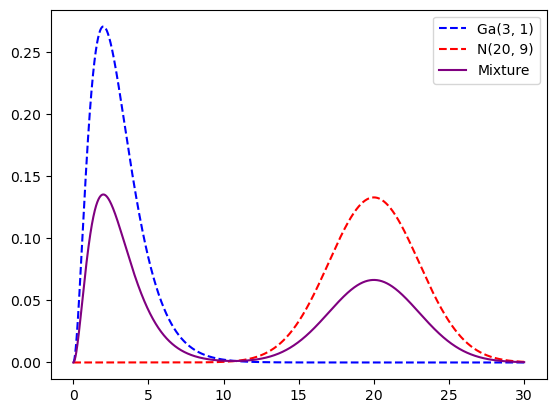

In [14]:
xx = np.linspace(0, 30, 1000000)


dist1 = gamma(a=3, scale=1)
dist2 = norm(loc=20, scale=3)

plt.plot(xx, dist1.pdf(xx), linestyle="dashed", color="blue", label="Ga(3, 1)")
plt.plot(xx, dist2.pdf(xx), linestyle="dashed", color="red", label="N(20, 9)")
plt.plot(xx, 0.5 * dist1.pdf(xx) + 0.5 * dist2.pdf(xx), color="purple", label="Mixture")
plt.legend()
plt.show()

In [15]:
samples = np.append(dist1.rvs(size=int(ct * 0.5)), dist2.rvs(size=int(ct * 0.5)))

Our calc_hdi function doesn't give a very useful answer.

In [16]:
calc_hdi(samples)

(0.41654205829274016, 23.99688611439793)

Neither does the equi-tailed credible set.

In [17]:
np.quantile(samples, [0.025, 0.975])

array([ 0.81681577, 24.93035592])

Instead use the Arviz [```hdi```](https://python.arviz.org/en/stable/api/generated/arviz.hdi.html) function with the multimodal argument or your favorite library's equivalent function.

In [18]:
az.hdi(samples, hdi_prob=0.95, multimodal=True)

array([[ 0.17861199,  6.94677139],
       [14.39858325, 25.61048368]])

In [19]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Thu Jul 06 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

arviz     : 0.15.1
numpy     : 1.24.2
matplotlib: 3.6.3

